# Phase 2: Baseline Stitching Method

This notebook implements the baseline stitching method using simple monthly mean scaling.

**Method**: Baseline (Simple Monthly Scaling)

**Algorithm**:
1. Average overlapping daily chunks to get raw daily series
2. Aggregate to monthly and compute scaling factors (alpha = truth / raw)
3. Scale daily values by monthly alpha

**Expected Performance**: Fast but less accurate than hierarchical methods. Target MAE: 5-10%.

**Outputs**:
- `interim/baseline/stitched_series.parquet`
- `interim/baseline/alpha_estimates.pkl`
- `interim/baseline/diagnostics.pkl`

## 0. Setup

In [1]:
# Setup
import sys
from pathlib import Path

# Add src to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / "src"))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from loguru import logger

from config import ConfigManager
from utils import FileManager, setup_logger
from stitching import BaselineStitcher

# Configure plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Imports successful")

✓ Imports successful


In [3]:
# Load configuration
config = ConfigManager(
    config_path=project_root / "config.yaml",
    env_path=project_root / ".env"
)
file_manager = FileManager(project_root)
file_manager.ensure_directories()

# Setup logging
log_file = file_manager.get_log_path("baseline_stitching.log")
setup_logger(log_file, level="INFO")

print(config.summary())

2025-11-12 23:44:55.417 | INFO     | config:__init__:221 - Loaded environment variables from /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/.env
2025-11-12 23:44:55.421 | INFO     | config:__init__:232 - Loaded configuration from /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/config.yaml
2025-11-12 23:44:55.421 | SUCCESS  | config:_parse_config:319 - Configuration validated successfully
2025-11-12 23:44:55.423 | INFO     | utils:ensure_directories:50 - Ensured all directories exist under /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing
2025-11-12 23:44:55 | INFO     | Logging to file: /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/logs/baseline_stitching.log


Configuration Summary
Search Term: flu vaccine
Geographic Location: GB
Date Range: 2022-01-01 to 2024-12-31 (1096 days)
Overlap: 60 days
Random Seed: 42

Stitching Weights:
  Monthly: 1.0
  Weekly: 0.5
  Overlap: 0.1

Zero Handling:
  Threshold: 0.01
  Structural Zero Months: [6, 7, 8]

Optimization:
  Max Iterations: 1000
  Tolerance: 1e-08

SerpAPI:
  Timeout: 90s
  Max Retries: 3
  Retry Delay: 10s


## 1. Load Data

Load the data collected in Phase 1:
- Monthly ground truth
- Weekly ground truth
- Daily chunks

In [4]:
# Load monthly data
monthly_path = file_manager.get_raw_data_path("monthly")
if not monthly_path.exists():
    raise FileNotFoundError(
        f"Monthly data not found at {monthly_path}. "
        "Please run notebook 01_data_collection.ipynb first."
    )

monthly_data = pd.read_parquet(monthly_path)
print(f"Loaded monthly data: {len(monthly_data)} months")
print(f"Date range: {monthly_data['date'].min()} to {monthly_data['date'].max()}")
monthly_data.head()

Loaded monthly data: 263 months
Date range: 2004-01-01 00:00:00 to 2025-11-01 00:00:00


,date,value,is_partial
0,2004-01-01,2,False
1,2004-02-01,2,False
2,2004-03-01,1,False
3,2004-04-01,1,False
4,2004-05-01,0,False


In [5]:
# Load weekly data
weekly_path = file_manager.get_raw_data_path("weekly")
weekly_data = None

if weekly_path.exists():
    weekly_data = pd.read_parquet(weekly_path)
    print(f"Loaded weekly data: {len(weekly_data)} weeks")
    print(f"Date range: {weekly_data['date'].min()} to {weekly_data['date'].max()}")
    display(weekly_data.head())
else:
    print("Weekly data not found (optional for baseline method)")

Loaded weekly data: 158 weeks
Date range: 2021-12-26 00:00:00 to 2024-12-29 00:00:00


,date,value,is_partial
0,2021-12-26,0.604251,False
1,2022-01-02,0.743693,False
2,2022-01-09,0.650732,False
3,2022-01-16,0.697213,False
4,2022-01-23,0.464808,False


In [6]:
# Load daily chunks
daily_chunks = []
chunk_idx = 0

while True:
    chunk_path = file_manager.get_daily_chunk_path(chunk_idx)
    if not chunk_path.exists():
        break

    chunk = pd.read_parquet(chunk_path)
    daily_chunks.append(chunk)
    chunk_idx += 1

if not daily_chunks:
    raise FileNotFoundError(
        f"No daily chunks found in {file_manager.data_daily_chunks}. "
        "Please run notebook 01_data_collection.ipynb first."
    )

print(f"Loaded {len(daily_chunks)} daily chunks")
print(f"Total observations: {sum(len(c) for c in daily_chunks)}")
print(f"Date range: {min(c['date'].min() for c in daily_chunks)} to {max(c['date'].max() for c in daily_chunks)}")

# Show chunk information
chunk_info = pd.DataFrame([
    {
        "chunk_id": i,
        "start": chunk["date"].min(),
        "end": chunk["date"].max(),
        "days": len(chunk),
        "mean_value": chunk["value"].mean(),
    }
    for i, chunk in enumerate(daily_chunks)
])
display(chunk_info)

Loaded 6 daily chunks
Total observations: 1396
Date range: 2022-01-01 00:00:00 to 2024-12-31 00:00:00


,chunk_id,start,end,days,mean_value
0,0,2022-01-01,2022-09-23,266,0.381283
1,1,2022-07-26,2023-04-17,266,0.627491
2,2,2023-02-17,2023-11-09,266,0.709794
3,3,2023-09-11,2024-06-02,266,0.799610
4,4,2024-04-04,2024-12-25,266,0.920181
5,5,2024-10-27,2024-12-31,66,2.403623


## 2. Run Baseline Stitching

Apply the baseline stitching method.

In [7]:
# Initialize baseline stitcher
stitcher = BaselineStitcher()

# Run stitching
logger.info("Starting baseline stitching...")
result = stitcher.stitch(daily_chunks, monthly_data, weekly_data, config)
logger.success("Baseline stitching completed")

# Display results summary
print(f"\nStitched series: {len(result.stitched_series)} days")
print(f"Date range: {result.stitched_series['date'].min()} to {result.stitched_series['date'].max()}")
print(f"Alpha estimates: {len(result.alpha_estimates)} values")
print(f"\nDiagnostics:")
print(f"  Monthly MAE: {result.diagnostics.get('monthly_mae', 'N/A'):.2f}")
print(f"  Monthly RMSE: {result.diagnostics.get('monthly_rmse', 'N/A'):.2f}")
if 'monthly_r2' in result.diagnostics:
    print(f"  Monthly R²: {result.diagnostics['monthly_r2']:.3f}")
if 'weekly_mae' in result.diagnostics:
    print(f"  Weekly MAE: {result.diagnostics['weekly_mae']:.2f}")
    print(f"  Weekly RMSE: {result.diagnostics['weekly_rmse']:.2f}")
    if 'weekly_r2' in result.diagnostics:
        print(f"  Weekly R²: {result.diagnostics['weekly_r2']:.3f}")
print(f"  Alpha mean: {result.diagnostics['alpha_mean']:.3f}")
print(f"  Alpha std: {result.diagnostics['alpha_std']:.3f}")
print(f"  Alpha CV: {result.diagnostics['alpha_cv']:.3f}")

2025-11-12 23:45:02 | INFO     | Starting baseline stitching...
2025-11-12 23:45:02 | INFO     | Starting baseline stitching method
2025-11-12 23:45:02 | INFO     | Step 1: Averaging overlapping daily chunks
2025-11-12 23:45:02 | INFO     | Averaged 1396 total observations to 1096 unique dates
2025-11-12 23:45:02 | INFO     | Step 2: Aggregating daily data to monthly
2025-11-12 23:45:02 | INFO     | Step 3: Computing monthly scaling factors
2025-11-12 23:45:02 | INFO     | Monthly alpha statistics (excluding structural zeros): mean=0.664, std=0.479, min=0.161, max=1.912
2025-11-12 23:45:02 | INFO     | Step 4: Scaling daily values
2025-11-12 23:45:02 | WARNING  | Baseline monthly MAE/RMSE use circular validation (training data = test data). Use weekly MAE for independent validation.
2025-11-12 23:45:02 | INFO     | Calculating weekly validation metrics...
2025-11-12 23:45:02 | INFO     | Diagnostics: Monthly MAE=0.00 (circular validation ⚠), Alpha CV=0.721 | Weekly MAE=0.70, Corr=0.936


Stitched series: 1096 days
Date range: 2022-01-01 00:00:00 to 2024-12-31 00:00:00
Alpha estimates: 36 values

Diagnostics:
  Monthly MAE: 0.00
  Monthly RMSE: 0.00
  Monthly R²: 1.000
  Weekly MAE: 0.70
  Weekly RMSE: 0.90
  Weekly R²: 0.412
  Alpha mean: 0.664
  Alpha std: 0.479
  Alpha CV: 0.721


## 3. Visualize Results

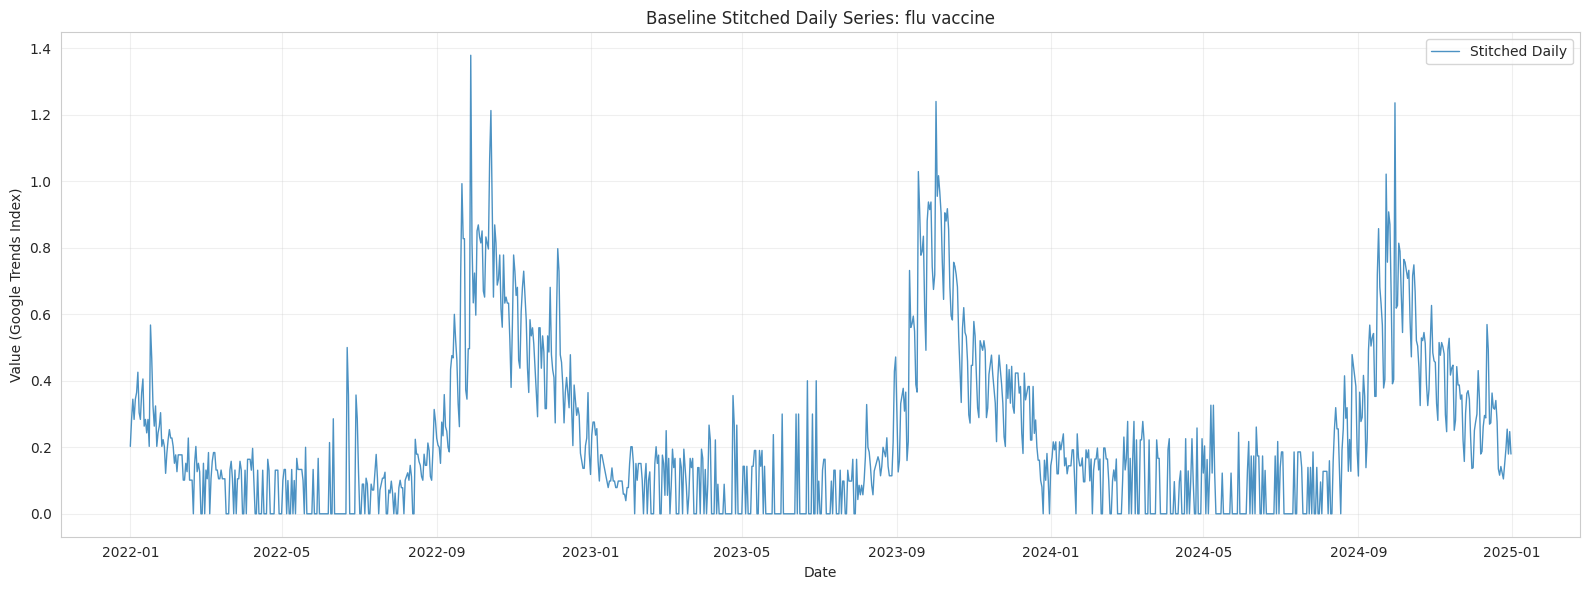

In [8]:
# Plot stitched daily series
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(result.stitched_series['date'], result.stitched_series['value'],
        linewidth=1, alpha=0.8, label='Stitched Daily')
ax.set_xlabel('Date')
ax.set_ylabel('Value (Google Trends Index)')
ax.set_title(f'Baseline Stitched Daily Series: {config.search_term}')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

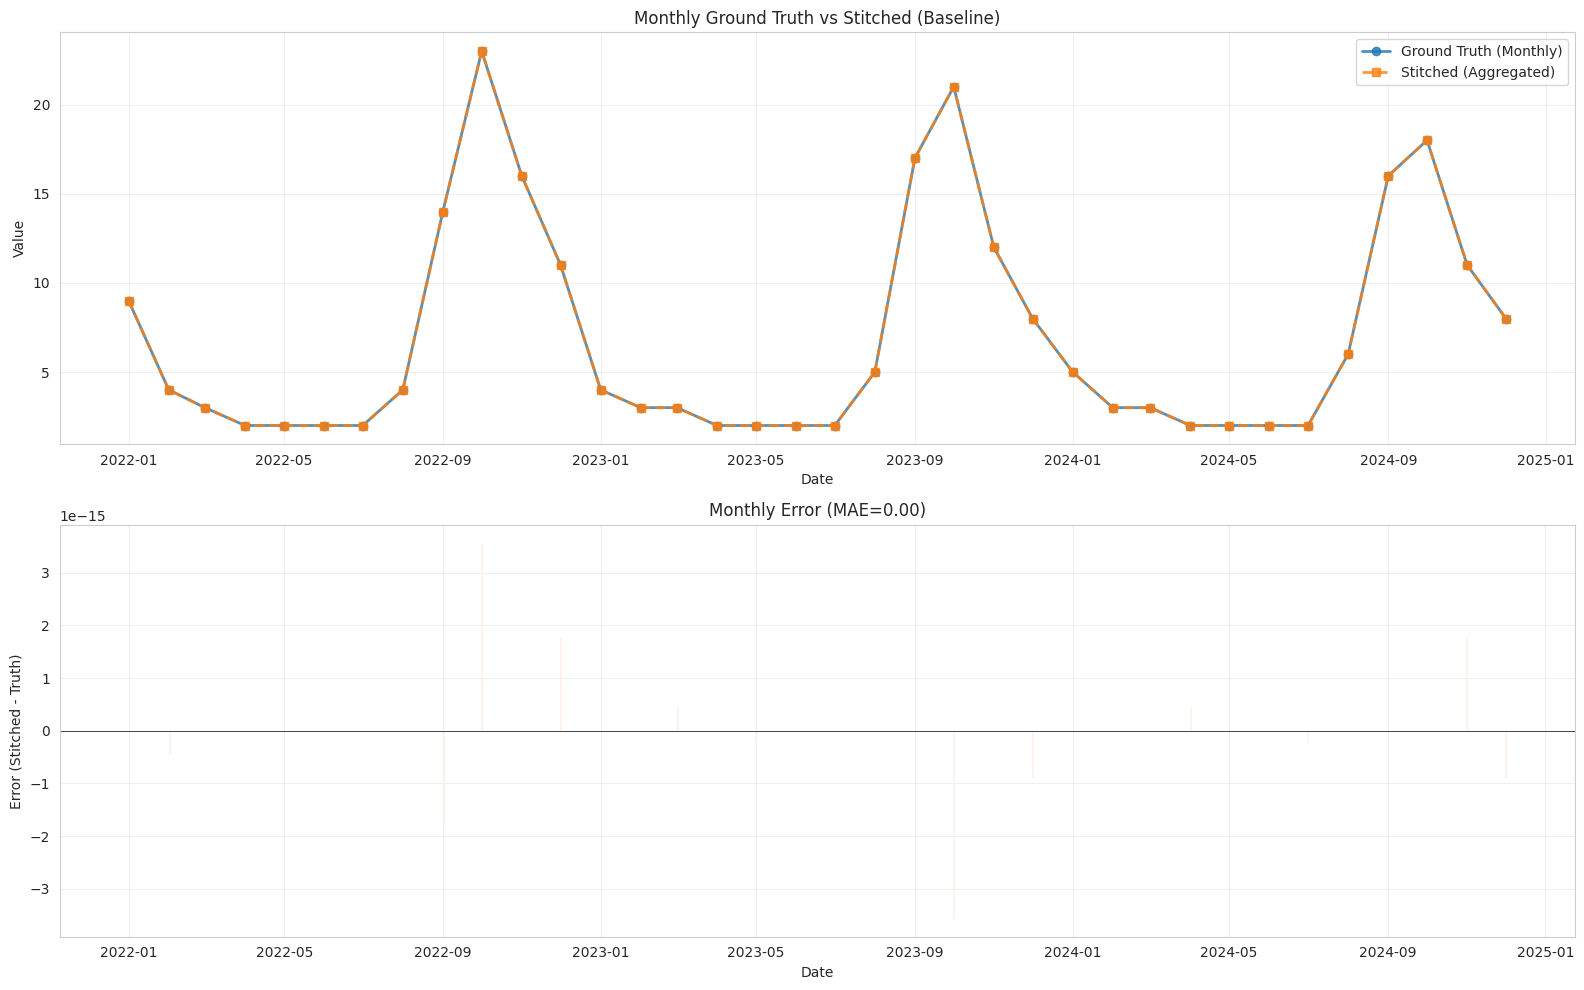

In [9]:
# Plot monthly comparison
if 'monthly_comparison' in result.diagnostics:
    monthly_comp = result.diagnostics['monthly_comparison']

    fig, axes = plt.subplots(2, 1, figsize=(16, 10))

    # Actual vs stitched
    axes[0].plot(monthly_comp['date'], monthly_comp['truth'],
                 marker='o', linewidth=2, label='Ground Truth (Monthly)', alpha=0.8)
    axes[0].plot(monthly_comp['date'], monthly_comp['stitched'],
                 marker='s', linewidth=2, linestyle='--', label='Stitched (Aggregated)', alpha=0.8)
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Value')
    axes[0].set_title('Monthly Ground Truth vs Stitched (Baseline)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Error plot
    axes[1].bar(monthly_comp['date'], monthly_comp['error'], alpha=0.7, color='coral')
    axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Error (Stitched - Truth)')
    axes[1].set_title(f"Monthly Error (MAE={result.diagnostics['monthly_mae']:.2f})")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

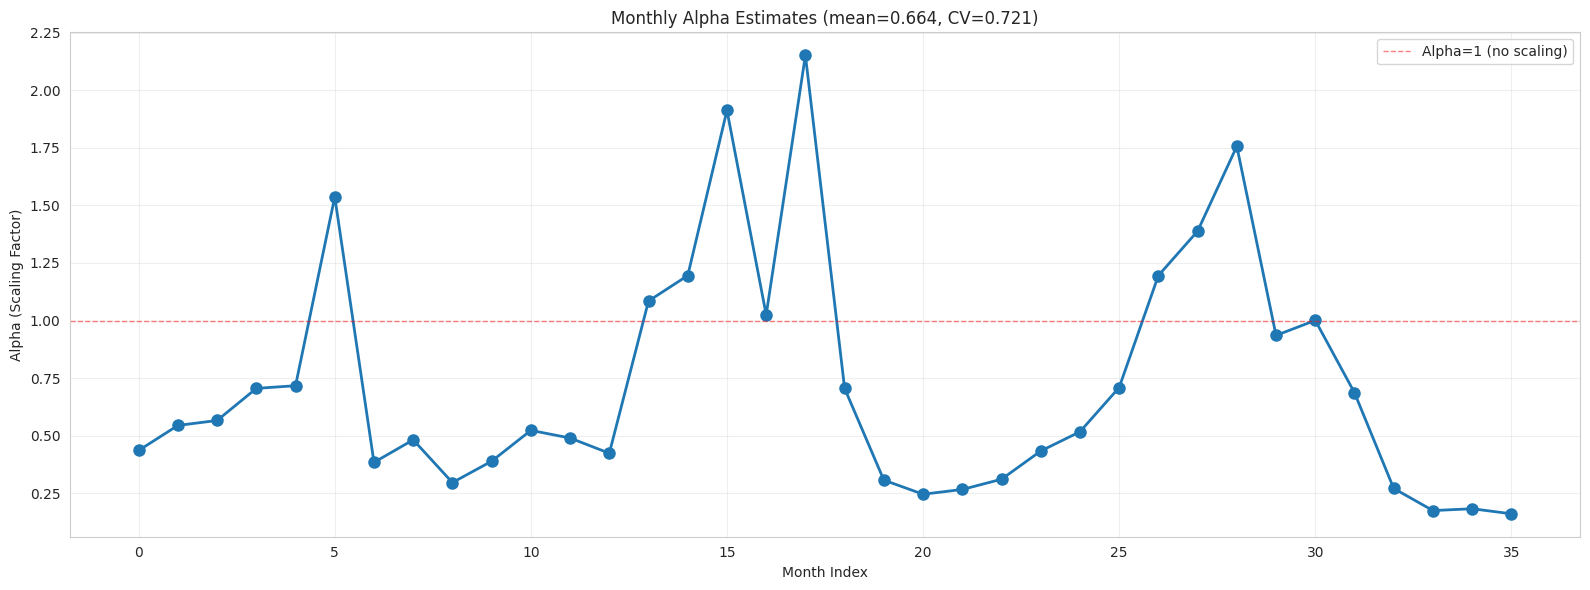

In [10]:
# Plot alpha estimates
if 'monthly_comparison' in result.diagnostics:
    monthly_comp = result.diagnostics['monthly_comparison']

    fig, ax = plt.subplots(figsize=(16, 6))
    ax.plot(range(len(result.alpha_estimates)), result.alpha_estimates,
            marker='o', linewidth=2, markersize=8)
    ax.axhline(y=1, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Alpha=1 (no scaling)')
    ax.set_xlabel('Month Index')
    ax.set_ylabel('Alpha (Scaling Factor)')
    ax.set_title(f'Monthly Alpha Estimates (mean={result.diagnostics["alpha_mean"]:.3f}, CV={result.diagnostics["alpha_cv"]:.3f})')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

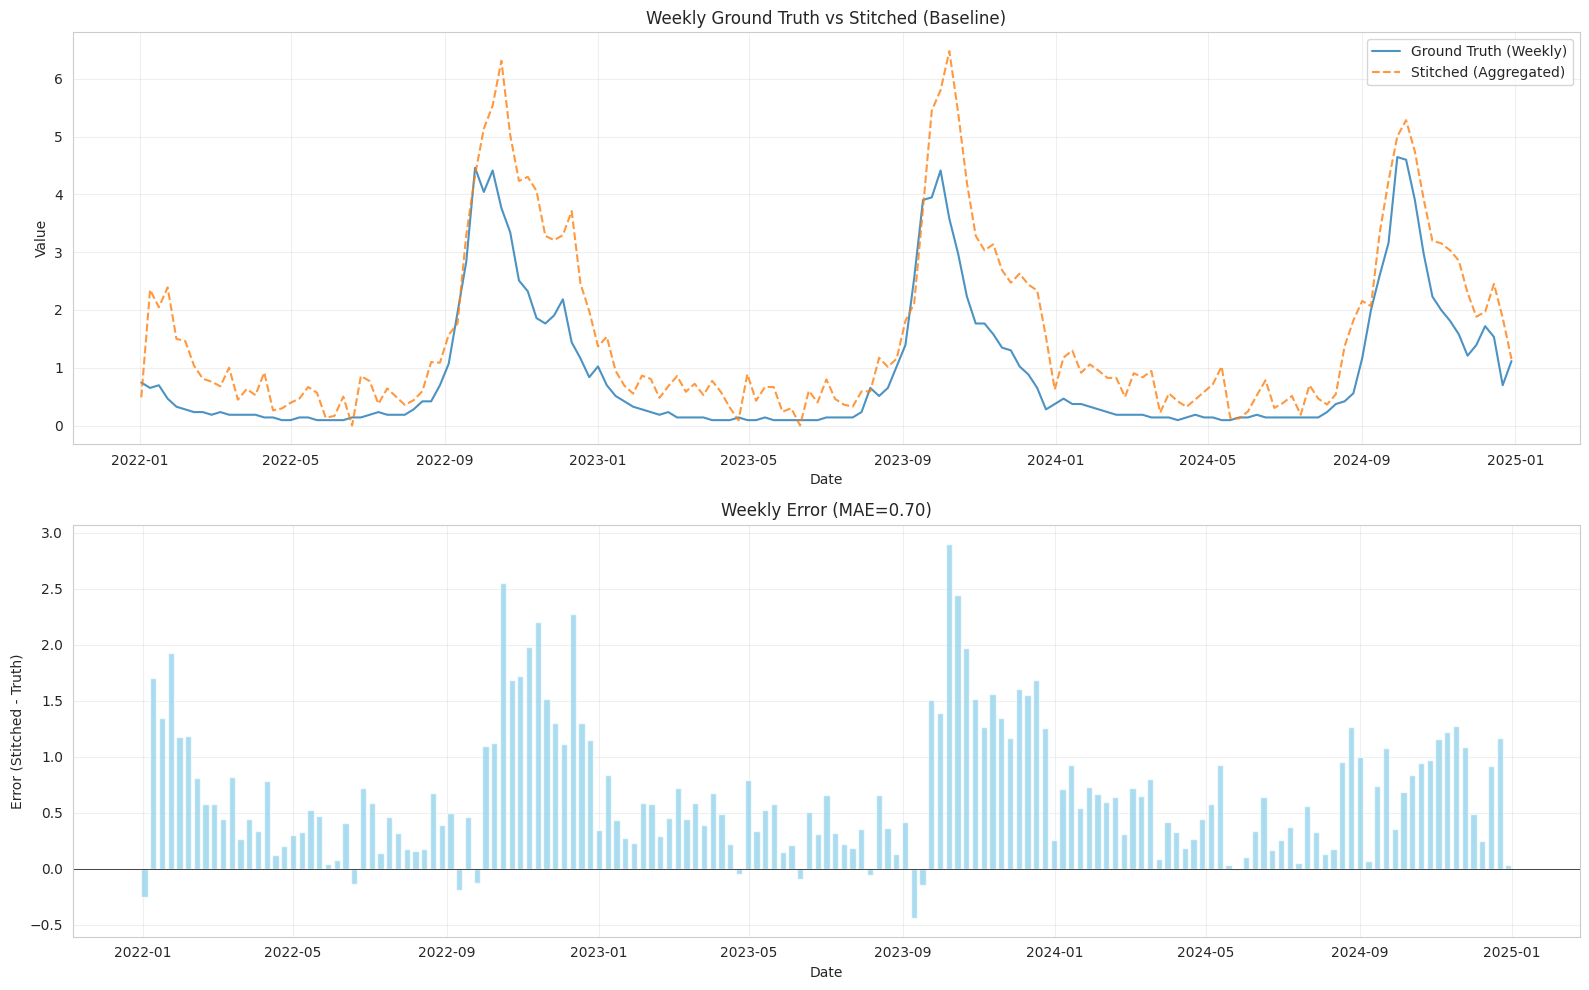

In [11]:
# Plot weekly comparison (if available)
if 'weekly_comparison' in result.diagnostics:
    weekly_comp = result.diagnostics['weekly_comparison']

    fig, axes = plt.subplots(2, 1, figsize=(16, 10))

    # Actual vs stitched
    axes[0].plot(weekly_comp['date'], weekly_comp['truth'],
                 linewidth=1.5, label='Ground Truth (Weekly)', alpha=0.8)
    axes[0].plot(weekly_comp['date'], weekly_comp['stitched'],
                 linewidth=1.5, linestyle='--', label='Stitched (Aggregated)', alpha=0.8)
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Value')
    axes[0].set_title('Weekly Ground Truth vs Stitched (Baseline)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Error plot
    axes[1].bar(weekly_comp['date'], weekly_comp['error'], alpha=0.7, color='skyblue', width=5)
    axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Error (Stitched - Truth)')
    axes[1].set_title(f"Weekly Error (MAE={result.diagnostics['weekly_mae']:.2f})")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

## 4. Save Results

In [13]:
# Save results
result.save(file_manager, "baseline")
logger.success(f"Results saved to {file_manager.interim / 'baseline'}")
print("\n✓ Baseline stitching complete!")

2025-11-12 23:46:01 | INFO     | Saved stitched series to /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/interim/baseline/stitched_series.parquet
2025-11-12 23:46:01 | INFO     | Saved alpha estimates to /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/interim/baseline/alpha_estimates.pkl
2025-11-12 23:46:01 | INFO     | Saved diagnostics to /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/interim/baseline/diagnostics.pkl
2025-11-12 23:46:01 | SUCCESS  | Results saved to /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/interim/baseline



✓ Baseline stitching complete!


## 5. Summary Statistics

In [14]:
# Create summary report
summary = f"""
BASELINE STITCHING SUMMARY
==========================

Search Term: {config.search_term}
Date Range: {config.date_range.start} to {config.date_range.end}
Overlap: {config.daily.overlap_days} days

DATA:
  Monthly observations: {len(monthly_data)}
  Weekly observations: {len(weekly_data) if weekly_data is not None else 'N/A'}
  Daily chunks: {len(daily_chunks)}
  Stitched daily points: {len(result.stitched_series)}

VALIDATION METRICS:

  ⚠️  MONTHLY (CIRCULAR VALIDATION - NOT MEANINGFUL):
      MAE: {result.diagnostics.get('monthly_mae', 'N/A'):.2e}
      RMSE: {result.diagnostics.get('monthly_rmse', 'N/A'):.2e}
"""

if 'monthly_corr' in result.diagnostics:
    summary += f"      Correlation: {result.diagnostics['monthly_corr']:.3f}\n"

summary += """
      WARNING: Monthly metrics use training data (α = truth/raw).
               Use weekly metrics for independent validation.
"""

if 'weekly_mae' in result.diagnostics:
    summary += f"""
  ✅ WEEKLY (INDEPENDENT VALIDATION - MEANINGFUL):
      MAE: {result.diagnostics['weekly_mae']:.2f}
      RMSE: {result.diagnostics['weekly_rmse']:.2f}
"""
    if 'weekly_corr' in result.diagnostics:
        summary += f"      Correlation: {result.diagnostics['weekly_corr']:.3f} (pattern similarity)\n"
    if 'weekly_nmae' in result.diagnostics:
        summary += f"      NMAE: {result.diagnostics['weekly_nmae']:.3f} (scale-invariant)\n"
    if 'weekly_bias_pct' in result.diagnostics:
        summary += f"      Bias: {result.diagnostics['weekly_bias_pct']:.1f}% (systematic deviation)\n"

summary += f"""
ALPHA STATISTICS:
  Mean: {result.diagnostics['alpha_mean']:.3f}
  Std: {result.diagnostics['alpha_std']:.3f}
  Min: {result.diagnostics['alpha_min']:.3f}
  Max: {result.diagnostics['alpha_max']:.3f}
  CV: {result.diagnostics['alpha_cv']:.3f}
"""

print(summary)

# Save summary to file
summary_path = file_manager.get_report_path("baseline_summary.txt")
with open(summary_path, 'w') as f:
    f.write(summary)
print(f"\nSummary saved to {summary_path}")


BASELINE STITCHING SUMMARY

Search Term: flu vaccine
Date Range: 2022-01-01 to 2024-12-31
Overlap: 60 days

DATA:
  Monthly observations: 263
  Weekly observations: 158
  Daily chunks: 6
  Stitched daily points: 1096

VALIDATION METRICS:

  ⚠️  MONTHLY (CIRCULAR VALIDATION - NOT MEANINGFUL):
      MAE: 4.44e-16
      RMSE: 1.01e-15
      Correlation: 1.000

               Use weekly metrics for independent validation.

  ✅ WEEKLY (INDEPENDENT VALIDATION - MEANINGFUL):
      MAE: 0.70
      RMSE: 0.90
      Correlation: 0.936 (pattern similarity)
      NMAE: 0.765 (scale-invariant)
      Bias: 74.4% (systematic deviation)

ALPHA STATISTICS:
  Mean: 0.664
  Std: 0.479
  Min: 0.161
  Max: 1.912
  CV: 0.721


Summary saved to /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/reports/baseline_summary.txt
